# Center Loss In Pytorch

### Center Loss With Pytorch

### A deployment on [the centerloss paper](https://ydwen.github.io/papers/WenECCV16.pdf) with pytorch

Gradient on center:

$\large \Delta c_{j} = \frac{\sum_{i-1}^m \delta(y_{i}=j).(c_{j}-x_{i})}{1+\sum_{i-1}^m \delta(y_{i}=j)}$

### Algorithm: The discriminative feature learning algorithm

**Input:** Traning data $\{x_{i}\}$. Initialized parameters $\theta_{C}$ in convolution layers(but in my experiment I only used linear). Parameters $W$ and $\{c_{j}|j=1,2,...,n\}$ in loss layers, respectively. Hyperparameter $\lambda$,$\alpha$ and learning rate $\mu_{t}$. The number of iteration $t\leftarrow0$.

**Output** The parameters $\theta_{C}$

* **While** not converge **do**
    * $t\leftarrow t+1$
    * Compute the joint loss by $\large L^t = L_{S}^t+L_{C}^t$
    * Compute the backpropagation error $\large \frac{\partial L^t}{\partial x_{i}^t}$ for each $i$ by $\large \frac{\partial L^t}{\partial x_{i}^t}=\frac{\partial L^t_{S}}{\partial x_{i}^t}+\lambda . \frac{\partial L^t_{C}}{\partial x_{i}^t}$
    * Update the parameters $W$ by $\large W^{t+1}=W^{t}-\mu_{t}.\frac{\partial L^t}{\partial W^t}=W^{t}-\mu^t.\frac{\partial L^t_{S}}{\partial W^t}$
    * Update the parameters $c_{j}$ for each $j$ by $\large c^{t+1}_{j}=c^{t}_{j}-\alpha . \Delta c^t_{j}$
    * Update the parameters $\theta_{C}$ by $\large \theta^{t+1}_{C}=\theta^{t}_{C} - \mu^t\sum^m_{i} \frac{\partial L^t}{\partial x^t_{i}}.\frac{\partial x^t_{i}}{\partial \theta^t_{C}}$
* end while

In [1]:
import numpy as np
import torch
from torch import nn
from torch import Tensor
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
from tqdm import trange # to make a pretty progress bar
from torch.optim import Adam,SGD 

### Data transformation pipe

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([.5,.5,.5],[.5,.5,.5])])

In [3]:
DL = False # Set this to True first time you run this
train_raw = MNIST("/data",train=True,transform=transform,download=DL)
val_raw = MNIST("/data",train=False,transform=transform,download=DL)

In [4]:
train_loader = DataLoader(train_raw,batch_size=16,shuffle=True,num_workers=2)
val_loader = DataLoader(val_raw,batch_size=16,shuffle=True,num_workers=2)

In [5]:
class dnn_mnist(nn.Module):
    def __init__(self,nb_feat):
        super(dnn_mnist,self).__init__()
        self.nb_feat = nb_feat
        self.fc1 = nn.Linear(784,self.nb_feat)
        self.fc2 = nn.Linear(self.nb_feat,10)
        
    def forward(self,x):
        # Reshape
        x = x.view(-1,784)
        # 1st layer & activation
        h = F.relu(self.fc1(x))
        # 2nd layer & activation
        x = F.softmax(self.fc2(h))
        return x,h
        

In [6]:
class center_loss(nn.Module):
    def __init__(self,nb_feat,nb_cls):
        super(center_loss,self).__init__()
        self.nb_feat = nb_feat
        self.nb_cls = nb_cls
        # self.centers dimension self.nb_feat * self.nb_cls
        self.centers = nn.Parameter(torch.randn(self.nb_feat,self.nb_cls))
    
    def forward(self,x,lbl):
        """
        In this calculation, lbl means the one hot encoding label
        x: bs * self.nb_feat
        lbl: bs * self.nb_cls
        """
        # print(x.t().size(),lbl.mm(self.centers.t()).size())
        return torch.mean(torch.pow(x-lbl.mm(self.centers.t()),2))

In [38]:
dnn = dnn_mnist(500)
clmd = center_loss(500,10)

In [39]:
params_dnn = list(dnn.parameters())
params_theta = params_dnn[:2]
params_w = params_dnn[2:]
params_closs = list(clmd.parameters())
len(params_w),len(params_closs),len(params_theta)
for param in [params_w,params_closs,params_theta,]:
    for mx in param:
        print(mx.size())
    print("="*60)

torch.Size([10, 500])
torch.Size([10])
torch.Size([500, 10])
torch.Size([500, 784])
torch.Size([500])


#### Check if using GPU

In [40]:
# torch.cuda.is_available() will return True or False on if this machine possess GPU/ is its CUDA ready
CUDA = torch.cuda.is_available()
if CUDA: 
    dnn.cuda()
    clmd.cuda()

#### Set Cross Entropy Loss Function

In [41]:
celoss=nn.CrossEntropyLoss()

#### Set Hyper-parameters: $\large \lambda$ , learning rate $\large \mu_{t}$ and $\large \alpha$

In [42]:
Lambda = 1e-2

mu_t = 1e-3    # learning rate for dnn
alpha = 5e-1    # learning rate for centers

In [43]:
# Use 3 optimizer on 3 parts of the parameters
opt_W = Adam(params_w, lr = mu_t)
opt_c = Adam(params_closs, lr = alpha)
opt_X = Adam(params_theta, lr = mu_t)

# Number of iterations to refresh messege
window=20

In [37]:
# A list for register scores
acc_stat1 = []

for epoch in range(1):
    train_gen,val_gen = iter(train_loader),iter(val_loader)
    r_loss_t,r_loss_s,r_loss_c,r_acc=0,0,0,0
    
    t=trange(len(train_loader))
    for i in t:
        x,y=train_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
            
        y_oh = torch.FloatTensor(y.size()[0],10)
        y_oh.zero_()
        y_oh = Variable(y_oh.scatter_(1,y.data.view(y.size()[0],1),1))
        
        y_,h = dnn(x)
        
        # Cross entropy loss
        Ls = celoss(y_,y)
        # Center loss
        Lc = clmd(h,y_oh)
        Lt = Ls + Lambda * Lc
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))

        # update W
        opt_W.zero_grad()
        Ls.backward(retain_variables=True)
        opt_W.step()
        
        # update center
        opt_c.zero_grad()
        Lc.backward(retain_variables=True)
        opt_c.step()
        
        # update theta
        opt_X.zero_grad()
        Lt.backward(retain_variables=True)
        opt_X.step()
        
        # Accumulate running loss
        r_loss_t += Lt.data[0]
        r_loss_s += Ls.data[0]
        r_loss_c += Lc.data[0]
        r_acc += acc.data[0]
        
        if i%window==(window-1): # refresh messege on progress bar every {window} of batch
            t.set_description("ep%s_bt%s\t Lt:\t%.2f\[tLc,Ls]:\t[%.2f,%.2f]\tacc:\t%.3f"%(epoch,
                                             i,
                                             r_loss_t/window,
                                             r_loss_c/window,
                                             r_loss_s/window,
                                             r_acc/window,
                                             ))
            
            # This list is for plotting charts
            acc_stat1.append(r_acc/window)
            r_loss_t,r_loss_s,r_loss_c,r_acc=0,0,0,0
    val_acc,val_l=0,0
    for i in range(len(val_loader)):
        x,y=val_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
        
        y_,h = dnn(x)
        Ls = celoss(y_,y)
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))
        val_acc += acc.data[0]
        val_l += Ls.data[0]
    val_acc /= len(val_loader)
    val_l /= len(val_loader)
    print("Validation [acc,loss]\t[%.3f,\t%.2f]"%(val_acc,val_l))

ep0_bt3739	 Lt:	1.55\[tLc,Ls]:	[1.17,1.54]	acc:	0.928: 100%|██████████| 3750/3750 [01:28<00:00, 42.15it/s]


Validation [acc,loss]	[0.921,	1.54]


### Now test on if we don't use Center Loss

In [44]:
CUDA = torch.cuda.is_available()
celoss=nn.CrossEntropyLoss()

Lambda = 1e-2

mu_t = 1e-3    # learning rate for dnn
alpha = 5e-1    # learning rate for centers

opt_X = Adam(params_dnn, lr = mu_t)

window=20

if CUDA: 
    dnn.cuda()
    clmd.cuda()
for epoch in range(1):
    train_gen,val_gen = iter(train_loader),iter(val_loader)
    r_loss_s,r_acc=0,0
    acc_stat2 = []
    t=trange(len(train_loader))
    for i in t:
        x,y=train_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
            
        y_oh = torch.FloatTensor(y.size()[0],10)
        y_oh.zero_()
        y_oh = Variable(y_oh.scatter_(1,y.data.view(y.size()[0],1),1))

        y_,h = dnn(x)
        
        # Cross entropy loss
        Ls = celoss(y_,y)

        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))

        # update theta
        opt_X.zero_grad()
        Ls.backward()
        opt_X.step()
        
        r_loss_s += Ls.data[0]
        r_acc += acc.data[0]
        
        if i%window==(window-1):
            t.set_description("ep%s_bt%s\t[Ls]:\t[%.2f]\tacc:\t%.3f"%(epoch,i,
                                             r_loss_s/window,
                                             r_acc/window,))
            acc_stat2.append(r_acc/window)
            r_acc,r_loss_s=0,0
    val_acc,val_l=0,0
    for i in range(len(val_loader)):
        x,y=val_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
        
        y_,h = dnn(x)
        Ls = celoss(y_,y)
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))
        val_acc += acc.data[0]
        val_l += Ls.data[0]
    val_acc /= len(val_loader)
    val_l /= len(val_loader)
    print("Validation [acc,loss]\t[%.3f,\t%.2f]"%(val_acc,val_l))

ep0_bt3739	[Ls]:	[1.56]	acc:	0.903: 100%|██████████| 3750/3750 [01:17<00:00, 48.65it/s]


Validation [acc,loss]	[0.934,	1.53]


In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

/Users/zhangxiaochen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['msyh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


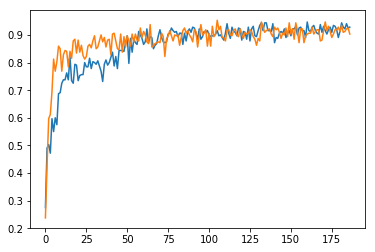

In [46]:
plt.plot(range(len(acc_stat1)),acc_stat1,range(len(acc_stat2)),acc_stat2)

### With Convolutions

In [19]:
class cnn_mnist(nn.Module):
    def __init__(self,nb_cls,fn_1=2**4,fn_2=2**5,fn_3=2**6,fn_out = 2**6,fc_h = 512):
        super(cnn_mnist,self).__init__()
        self.nb_cls = nb_cls
        self.fn_out = fn_out
        self.fn_1=fn_1
        self.fn_2=fn_2
        self.fn_3=fn_3
        self.fc_h = 512
        
        self.conv1 = nn.Conv2d(1,self.fn_1,(3,3),stride=(1,1), padding=1)
        self.conv2 = nn.Conv2d(self.fn_1,self.fn_1,(3,3),stride=(1,1), padding=1)
        self.bn1= nn.BatchNorm2d(self.fn_1)
        
        self.conv3 = nn.Conv2d(self.fn_1,self.fn_1,(3,3),stride=1, padding=1)
        self.conv4 = nn.Conv2d(self.fn_1,self.fn_2,(3,3),stride=1, padding=1)
        self.bn2= nn.BatchNorm2d(self.fn_2)
        
        self.conv5 = nn.Conv2d(self.fn_2,self.fn_3,(3,3),stride=1, padding=1)
        self.conv6 = nn.Conv2d(self.fn_3,self.fn_out,(3,3),stride=1, padding=1)
        self.bn3= nn.BatchNorm2d(self.fn_out)
        
        self.pool = nn.MaxPool2d((2,2))
        
        self.fc1 = nn.Linear(3*3*self.fn_out,self.fc_h)
        self.bn_fc = nn.BatchNorm1d(self.fc_h)
        self.dropout = nn.Dropout(.3)
        self.fc2 = nn.Linear(self.fc_h,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(self.bn1(x))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(self.bn2(x))
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(self.bn3(x))
        
        x = x.view(-1,3*3*self.fn_out)
        h = self.dropout(self.bn_fc(F.relu(self.fc1(x))))
        x = F.softmax(self.fc2(h))
        return x,h

In [20]:
dnn = cnn_mnist(10)
clmd = center_loss(512,10)

In [21]:
dnn

cnn_mnist (
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (576 -> 512)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (dropout): Dropout (p = 0.3)
  (fc2): Linear (512 -> 10)
)

In [22]:
params_dnn = list(dnn.parameters())
params_theta = params_dnn[:-2]
params_w = params_dnn[-2:]
params_closs = list(clmd.parameters())
len(params_w),len(params_closs),len(params_theta)
for param in [params_w,params_closs,params_theta,]:
    for mx in param:
        print(mx.size())
    print("="*60)

torch.Size([10, 512])
torch.Size([10])
torch.Size([512, 10])
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([512, 576])
torch.Size([512])
torch.Size([512])
torch.Size([512])


In [17]:
# torch.cuda.is_available() will return True or False on if this machine possess GPU/ is its CUDA ready
CUDA = torch.cuda.is_available()
if CUDA: 
    dnn.cuda()
    clmd.cuda()
    
celoss=nn.CrossEntropyLoss()

Lambda = 1e-2

mu_t = 1e-3    # learning rate for dnn
alpha = 5e-1    # learning rate for centers

# Use 3 optimizer on 3 parts of the parameters
opt_W = Adam(params_w, lr = mu_t)
opt_c = Adam(params_closs, lr = alpha)
opt_X = Adam(params_theta, lr = mu_t)

# Number of iterations to refresh messege
window=20

In [18]:
# A list for register scores
acc_stat1 = []

for epoch in range(1):
    train_gen,val_gen = iter(train_loader),iter(val_loader)
    r_loss_t,r_loss_s,r_loss_c,r_acc=0,0,0,0
    
    t=trange(len(train_loader))
    for i in t:
        x,y=train_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
            
        y_oh = torch.FloatTensor(y.size()[0],10)
        y_oh.zero_()
        y_oh = Variable(y_oh.scatter_(1,y.data.view(y.size()[0],1),1))
        
        y_,h = dnn(x)
        
        # Cross entropy loss
        Ls = celoss(y_,y)
        # Center loss
        Lc = clmd(h,y_oh)
        Lt = Ls + Lambda * Lc
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))

        # update W
        opt_W.zero_grad()
        Ls.backward(retain_variables=True)
        opt_W.step()
        
        # update center
        opt_c.zero_grad()
        Lc.backward(retain_variables=True)
        opt_c.step()
        
        # update theta
        opt_X.zero_grad()
        Lt.backward(retain_variables=True)
        opt_X.step()
        
        # Accumulate running loss
        r_loss_t += Lt.data[0]
        r_loss_s += Ls.data[0]
        r_loss_c += Lc.data[0]
        r_acc += acc.data[0]
        
        if i%window==(window-1): # refresh messege on progress bar every {window} of batch
            t.set_description("ep%s_bt%s\t Lt:\t%.2f\t[Lc,Ls]:\t[%.2f,%.2f]\tacc:\t%.3f"%(epoch,
                                             i,
                                             r_loss_t/window,
                                             r_loss_c/window,
                                             r_loss_s/window,
                                             r_acc/window,
                                             ))
            
            # This list is for plotting charts
            acc_stat1.append(r_acc/window)
            r_loss_t,r_loss_s,r_loss_c,r_acc=0,0,0,0
    val_acc,val_l=0,0
    for i in range(len(val_loader)):
        x,y=val_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
        
        y_,h = dnn(x)
        Ls = celoss(y_,y)
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))
        val_acc += acc.data[0]
        val_l += Ls.data[0]
    val_acc /= len(val_loader)
    val_l /= len(val_loader)
    print("Validation [acc,loss]\t[%.3f,\t%.2f]"%(val_acc,val_l))

ep0_bt3739	 Lt:	1.49\[tLc,Ls]:	[0.38,1.49]	acc:	0.975: 100%|██████████| 3750/3750 [09:17<00:00,  6.73it/s]


Validation [acc,loss]	[0.983,	1.48]


### CNN with out center loss

In [23]:
CUDA = torch.cuda.is_available()
celoss=nn.CrossEntropyLoss()

Lambda = 1e-2

mu_t = 1e-3    # learning rate for dnn
alpha = 5e-1    # learning rate for centers

opt_X = Adam(params_dnn, lr = mu_t)

window=20

if CUDA: 
    dnn.cuda()
    clmd.cuda()
for epoch in range(1):
    train_gen,val_gen = iter(train_loader),iter(val_loader)
    r_loss_s,r_acc=0,0
    acc_stat2 = []
    t=trange(len(train_loader))
    for i in t:
        x,y=train_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
            
        y_oh = torch.FloatTensor(y.size()[0],10)
        y_oh.zero_()
        y_oh = Variable(y_oh.scatter_(1,y.data.view(y.size()[0],1),1))

        y_,h = dnn(x)
        
        # Cross entropy loss
        Ls = celoss(y_,y)

        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))

        # update theta
        opt_X.zero_grad()
        Ls.backward()
        opt_X.step()
        
        r_loss_s += Ls.data[0]
        r_acc += acc.data[0]
        
        if i%window==(window-1):
            t.set_description("ep%s_bt%s\t[Ls]:\t[%.2f]\tacc:\t%.3f"%(epoch,i,
                                             r_loss_s/window,
                                             r_acc/window,))
            acc_stat2.append(r_acc/window)
            r_acc,r_loss_s=0,0
    val_acc,val_l=0,0
    for i in range(len(val_loader)):
        x,y=val_gen.__next__()
        x,y=Variable(x),Variable(y)
        if CUDA:
            x.cuda()
            y.cuda()
        
        y_,h = dnn(x)
        Ls = celoss(y_,y)
        y_max,y_idx = torch.max(y_,1)
        acc = torch.mean(torch.eq(y_idx,y).type(torch.FloatTensor))
        val_acc += acc.data[0]
        val_l += Ls.data[0]
    val_acc /= len(val_loader)
    val_l /= len(val_loader)
    print("Validation [acc,loss]\t[%.3f,\t%.2f]"%(val_acc,val_l))

ep0_bt3739	[Ls]:	[1.49]	acc:	0.975: 100%|██████████| 3750/3750 [05:17<00:00, 11.82it/s]


Validation [acc,loss]	[0.979,	1.48]


/Users/zhangxiaochen/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['msyh'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


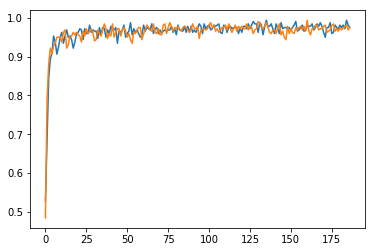

In [26]:
plt.plot(range(len(acc_stat1)),acc_stat1,range(len(acc_stat2)),acc_stat2)